In [3]:
import re
import csv
import glypy
import pickle
import random
import itertools
import matplotlib
import collections
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from queue import Queue
from glypy import plot
from glypy.io import glycoct
from glypy.structure.glycan import fragment_to_substructure
from glypy.structure.glycan_composition import MonosaccharideResidue, GlycanComposition

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

mass_tolerance = 0.5
mass_proton = 1.00727647
mass_free_reducing_end = 18.01056468370001
sugar_classes_name = ['Fuc', 'Man', 'GlcNAc', 'NeuAc', 'NeuGc']
sugar_classes = [glypy.monosaccharides[name].mass() - mass_free_reducing_end for name in sugar_classes_name]


def y_ions(targlycan):
    glycan_list = []
    glycan = targlycan.clone().reindex(method='bfs')

    glycan_list.append(glycan)
    q = Queue()
    q.put(glycan)
    while not q.empty():
        glycan = q.get()
        glycan.reindex(method='bfs')
        for i in range(len(list(glycan.leaves()))):
            tem = glycan.clone().reindex(method='bfs')
            leave = list(tem.leaves())[i]
            if leave.parents() == []:
                continue
            parent = leave.parents()[0][-1]
            children = parent.children()

            for idx in range(len(children)):
                tem1 = tem.clone()
                leave1 = list(tem1.leaves())[i]
                parent1 = leave1.parents()[0][-1]
                children1 = parent1.children()
                # print(children1)
                child1 = children1[idx]
                child_pos1 = child1[0]
                parent1.drop_monosaccharide(child_pos1)
                
                flag = 1
                for glycan1 in glycan_list:
                    if topological_equality(glycan1.root,tem1.root):  
                        flag =0  
                        break
                if flag == 1:
                    glycan_list.append(tem1.reindex(method='bfs'))
                    q.put(tem1.clone().reindex(method='bfs'))
                
    return glycan_list

def b_ions(targlycan):
    glycan_list = []
    glycan = targlycan.clone().reindex(method='bfs')
    q = Queue()
    q.put(glycan)
    
    while not q.empty():
        glycan = q.get()
        glycan.reindex(method='bfs')

        for links, frags in itertools.groupby(glycan.clone().fragments(), lambda f: f.link_ids.keys()):  
            frags = list(frags)
            y_ion, b_ion = frags
            y_tree, b_tree = [fragment_to_substructure(frag, glycan) for frag in (y_ion, b_ion)]
            flag = 1
            for glycan1 in glycan_list:
                if topological_equality(glycan1.root,b_tree.root):  
                    flag =0  
            if flag == 1:
                glycan_list.append(b_tree.reindex(method='bfs'))
                q.put(b_tree.clone().reindex(method='bfs'))
            flag = 1
            for glycan1 in glycan_list:
                if topological_equality(glycan1.root,y_tree.root):  
                    flag =0  
            if flag == 1:
                glycan_list.append(y_tree.reindex(method='bfs'))
                q.put(y_tree.clone().reindex(method='bfs'))
            
    return glycan_list


def glycan_to_tree(node):
    root = TreeNode()
    index = sugar_classes.index(MonosaccharideResidue.from_monosaccharide(node).mass())
    if index == 0 :
        root.shape = 'tri'
    elif index == 1 :
        root.shape = 'circle'
    elif index == 2:
        root.shape = 'square'
    elif index == 3:
        root.shape = 'diamond'
    children = []
    for child in node.children():
        tem = glycan_to_tree(child[1])
        children.append(tem)
    root.children = children
    return root  

def calculate_tree_dimensions(node, level=1):
    if not node.children:
        return level, 1
    max_depth = level
    max_width = 0
    for child in node.children:
        child_depth, child_width = calculate_tree_dimensions(child, level + 1)
        max_depth = max(max_depth, child_depth)
        max_width += child_width
    return max_depth, max_width

class TreeNode:
    def __init__(self, shape=None, children=None):
        self.shape = shape
        self.children = children if children is not None else []
        self.visited = False

def draw_tree(ax, node, x, y, width=2, level_height=3):
    node_width = 10.0
    shape = node.shape
    
    def draw_node(x, y, shape):
        if shape == 'circle':  
            node_patch = patches.Ellipse((x, y-0.5), width=node_width+0.5, height=node_width+0.5, angle=0, edgecolor='black', facecolor='#01a650',zorder=2)
        elif shape == 'square':
            node_patch = patches.Rectangle((x - node_width / 2, y - node_width / 2 ), width=node_width, height=node_width, angle=0,rotation_point='center',edgecolor='black', facecolor='#0180ff',zorder=2)
        elif shape == 'diamond':
            node_patch = patches.Polygon([(x - node_width / 2, y ),(x , y + node_width / 2),(x + node_width / 2, y ),(x , y - node_width / 2)],  closed=True,edgecolor='black', facecolor='#a21fff',zorder=2)
        elif shape == 'tri':
            node_patch = patches.Polygon([(x - node_width / 2, y ),(x + node_width / 2, y - node_width / 2),(x + node_width / 2, y + node_width / 2)],  closed=True,edgecolor='black', facecolor='#fc0200',zorder=2)
        elif shape == 'pep':
            node_patch = patches.Rectangle((x - node_width / 2, y - node_width / 4 ), width=node_width, height=node_width/4, angle=0,rotation_point='center',edgecolor='black', facecolor='black',zorder=2)
        ax.add_patch(node_patch)
    def draw_edge(x_start, x_end, y_start,y_end):
        ax.plot([x_start, x_end], [y_start,y_end], color='black', linestyle='-', linewidth=1,zorder=1)

    if node.children:
        num_children = 0
        for child in node.children:
            if child.shape != 'tri':
                num_children+=1
        x_start = x - (num_children - 1) * width / 2

        for child in node.children:
            if len(node.children)==1 and child.shape == 'tri':
                draw_tree(ax, child, x+width, y , width, level_height)
                draw_edge(x, x+width, y,y)
                continue
            x_pos = x_start
            if child.shape == 'tri':
                draw_tree(ax, child, x_pos, y , width, level_height)
                draw_edge(x, x_pos, y,y)
            else:
                draw_tree(ax, child, x_pos, y + level_height, width, level_height)
                draw_edge(x, x_pos, y,y + level_height)
                x_start += width
    draw_node(x, y, shape)

def topological_equality(predict, traget):
    taken_b = set()
    b_children = list(traget.children(links=True))
    a_children = list(predict.children(links=True))
    if predict.mass() == traget.mass():
        for a_pos, a_link in a_children:
            a_child = a_link.child
            matched = False
            for b_pos, b_link in b_children:
                b_child = b_link.child
                if (b_pos, b_child.id) in taken_b:
                    continue
                if topological_equality(a_child,b_child):          
                    matched = True
                    taken_b.add((b_pos, b_child.id))
                    break
            if not matched and len(a_children) > 0:
                return False
        if len(taken_b) != len(b_children):  
            return False
        return True
    return False

def read_spectrum(input_spectrum_file, spectrum_location_dict, scan_id, peptide_mass):
    input_spectrum_handle = open(input_spectrum_file, 'r')
    spectrum_location = spectrum_location_dict[scan_id]
    input_file_handle = input_spectrum_handle
    input_file_handle.seek(spectrum_location)

    line = input_file_handle.readline()
    line = input_file_handle.readline()
    line = input_file_handle.readline()
    line = input_file_handle.readline()
    line = input_file_handle.readline()
    line = input_file_handle.readline()
    line = input_file_handle.readline()
    line = input_file_handle.readline()
    line = input_file_handle.readline()

    mz_list = []
    intensity_list = []
    line = input_file_handle.readline()
    while not "END IONS" in line:
        mz, intensity = re.split(' |\n', line)[:2]
        mz_float = float(mz)
        intensity_float = float(intensity)
        mz_list.append(mz_float)
        intensity_list.append(intensity_float)
        line = input_file_handle.readline()

    return mz_list, intensity_list

num_fractions = 5
tissue_name = ['MouseBrain', 'MouseHeart', 'MouseKidney', 'MouseLiver', 'MouseLung']
input_spectrum_file = 'sample_data/mouse-tissue-all-refined.mgf'
spectrum_location_file = input_spectrum_file + '.locations.pkl'
with open(spectrum_location_file, 'rb') as fr:
    data = pickle.load(fr)
    spectrum_location_dict, spectrum_rtinseconds_dict, spectrum_count = data\

with open('sample_data/all.pkl', 'rb') as f:
    glycan_dict = pickle.load(f)
with open('sample_data/match.csv', 'r') as csvfile:
    csvreader = csv.DictReader(csvfile)
    for row in csvreader:
        precursor_mass = float(row['Mass'])
        target_glycan_mass = float(row['Glycan Mass'])
        adduct_mass = float(row['Adduct Mass'])
        isotope_shift = float(row['Isotopic Shift'])
        peptide_only_mass = precursor_mass - target_glycan_mass - adduct_mass +isotope_shift * mass_proton + mass_proton
        
        target_glycan_id = row['Glycan ID']
        target_glycan = glycan_dict[target_glycan_id]['GLYCAN']

        psm_scan = row['Scan']
        tissue = row['Source File'].split('-')[0]
        tissue_id = tissue_name.index(tissue)
        fraction = int(row['Source File'].split('.')[0][-1])
        fraction_id = tissue_id * num_fractions + fraction
        scan = 'F' + str(fraction_id) + ':' + psm_scan

        mz, intensity = read_spectrum(input_spectrum_file, spectrum_location_dict, scan, peptide_only_mass)

In [4]:
mz, intensity

([121.02839,
  126.05492,
  127.03915,
  138.05484,
  144.0654,
  150.05489,
  151.03879,
  154.04979,
  163.05963,
  166.04941,
  167.03369,
  168.06529,
  172.06,
  178.04942,
  179.03371,
  182.04451,
  184.06029,
  186.07578,
  196.06032,
  197.04433,
  204.08636,
  208.05962,
  214.07089,
  215.05455,
  226.07002,
  226.11838,
  229.09225,
  232.0811,
  238.07112,
  238.11783,
  256.08121,
  258.14465,
  260.19568,
  274.09171,
  282.14493,
  285.15527,
  287.13446,
  290.08136,
  292.10229,
  294.10794,
  297.15591,
  299.17044,
  310.11169,
  311.13382,
  314.12485,
  323.17136,
  325.11081,
  326.17181,
  328.16132,
  329.181,
  330.11777,
  338.18234,
  340.15945,
  341.1828,
  348.12839,
  350.14377,
  352.08774,
  352.16235,
  355.19675,
  358.11285,
  366.13882,
  368.14383,
  369.14523,
  370.17065,
  372.22583,
  384.14191,
  384.19064,
  394.17087,
  399.19769,
  400.21777,
  407.16495,
  411.19937,
  412.18411,
  418.13339,
  418.19052,
  423.19757,
  427.18658,
  429.2

(-1.0999999999999999, 2.6666666666666674)

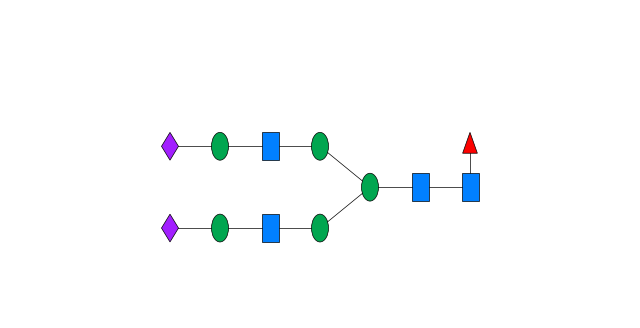

In [19]:
dt, ax = plot.plot(target_glycan, label=False)
ax.figure.set_figwidth(8)
ax.figure.set_figheight(4)
lo, hi = ax.get_ylim()
ax.set_ylim(lo / 2, hi / 1.2)
    

In [20]:
tree_glycopsm_list= y_ions(target_glycan)
b_list_tem= b_ions(target_glycan)
b_list= []

for glycan in b_list_tem:
    flag= 1
    for yion in tree_glycopsm_list[:-1]:
        if topological_equality(glycan.root,yion.root):
            flag=0
    if flag == 1:
        b_list.append(glycan.reindex(method='bfs'))

tree_glycopsm_list= sorted(tree_glycopsm_list,key=lambda x: x.mass())
b_list= sorted(b_list,key=lambda x: x.mass())

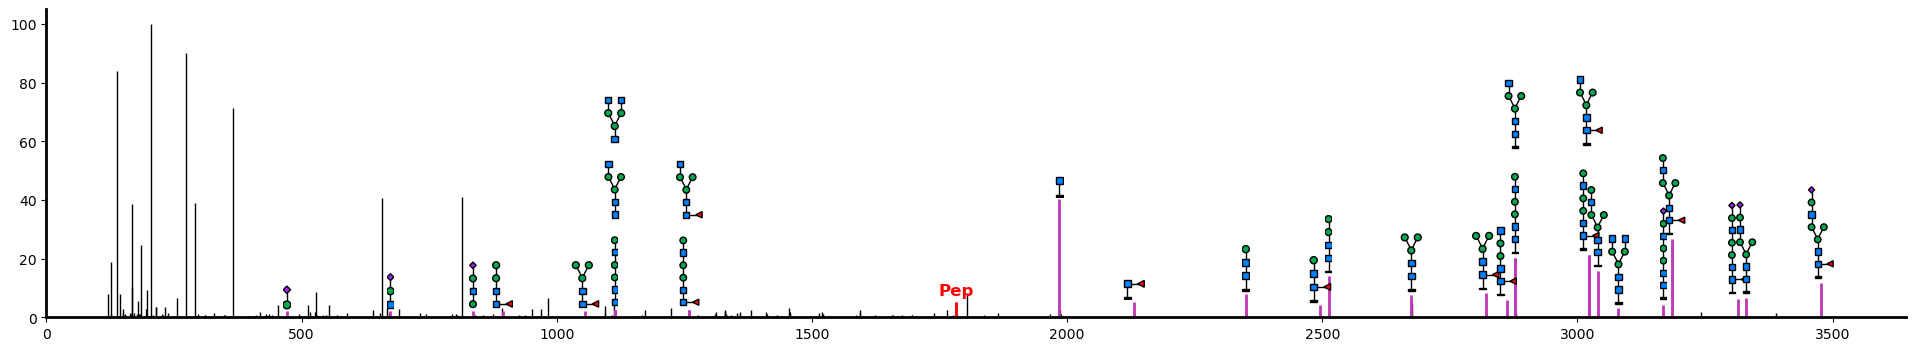

In [24]:
mz = np.array(mz)
intensity= np.array(intensity)
intensity = intensity /max(intensity) * 100

fig, ax = plt.subplots(figsize=(24,4),dpi=100)  
for m, i in zip(mz, intensity):
    ax.vlines(m, 0, i, color='black', linewidth=1)
peak_index = random.randint(0, len(mz) - 1)

ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['bottom'].set_linewidth(2)  
ax.spines['left'].set_linewidth(2)    


width = 0.3  
height = 0.3

remark_mz = dict()

# only peptide
matched = np.isclose(mz, peptide_only_mass, atol=mass_tolerance, rtol=0)
matched_idx = np.nonzero(matched)
idx1 = 0
if len(matched_idx[0]) == 0:
    1
elif len(matched_idx[0]) > 1:
    idx1 = np.argmin(abs(mz[i]-mass) for i in matched_idx[0])
    matched_mass = mz[matched_idx[0][idx1]]
else:
    matched_mass = mz[matched_idx[0][0]]
    idx1 = 0
if len(matched_idx[0]) != 0:
    ax.text(mz[matched_idx[0][idx1]], intensity[matched_idx[0][idx1]]+4, 'Pep', fontsize=12, color='red', weight='bold',
        horizontalalignment='center', verticalalignment='center')
    ax.vlines(mz[matched_idx[0][idx1]],0, intensity[matched_idx[0][idx1]], color='red', linewidth=2,zorder=2)

# Y-ions
num = 0
for idx, tree in enumerate(tree_glycopsm_list):
    tree = tree
    mass = tree.mass()
    mass1 = peptide_only_mass + mass - mass_free_reducing_end
    matched = np.isclose(mz, mass, atol=mass_tolerance, rtol=0)
    matched_idx = np.nonzero(matched)
    idx1 = 0
    if len(matched_idx[0]) == 0:
        1
    elif len(matched_idx[0]) > 1:
        idx1 = np.argmin(abs(mz[i]-mass) for i in matched_idx[0])
        matched_mass = mz[matched_idx[0][idx1]]
    else:
        matched_mass = mz[matched_idx[0][0]]
        idx1 = 0
    if len(matched_idx[0]) != 0:
        
        root = glycan_to_tree(tree.root)
        max_depth, max_width = calculate_tree_dimensions(root)
        if len(root.children)==1 and root.children[0].shape=='tri':
            max_width = 2
            max_depth = 1 
    
        if len(root.children)==0:
            max_depth=0.5
            max_width =0.5
        box_y = intensity[matched_idx[0][idx1]]

        if float(mz[matched_idx[0][idx1]]) in remark_mz.keys():
            ax_inset = inset_axes(ax, width=max_width/8, height=max_depth/8, loc=8,
                        bbox_to_anchor=(mz[matched_idx[0][idx1]], box_y+max_depth*6*remark_mz[mz[matched_idx[0][idx1]]]),
                        bbox_transform=ax.transData)
            remark_mz[float(mz[matched_idx[0][idx1]])] += 1
        else:
            ax_inset = inset_axes(ax, width=max_width/8, height=max_depth/8, loc=8,
                        bbox_to_anchor=(mz[matched_idx[0][idx1]], box_y),
                        bbox_transform=ax.transData)
            remark_mz[float(mz[matched_idx[0][idx1]])] = 1

        ax_inset.set_aspect('equal')  

        draw_tree(ax_inset, root, 0, 0, width=20, level_height=20)
        for spine in ax_inset.spines.values():
            spine.set_visible(False)

        ax_inset.set_xticks([])
        ax_inset.set_yticks([])
        ax_inset.set_facecolor('none')

        ax.vlines(mz[matched_idx[0][idx1]],0, intensity[matched_idx[0][idx1]]+2, color='#bf38b9', linewidth=2,zorder=2)

    idx1 = 0
    mass = peptide_only_mass + mass - mass_free_reducing_end
    matched = np.isclose(mz, mass, atol=mass_tolerance, rtol=0)
    matched_idx = np.nonzero(matched)
    if len(matched_idx[0]) == 0:
        1
    elif len(matched_idx[0]) > 1:
        idx1 = np.argmin(abs(mz[i]-mass) for i in matched_idx[0])
        matched_mass = mz[matched_idx[0][idx1]]
    else:
        matched_mass = mz[matched_idx[0][0]]
        idx1 = 0
    if len(matched_idx[0]) != 0:
        
        root = glycan_to_tree(tree.root)
        max_depth, max_width = calculate_tree_dimensions(root)
        max_depth += 1
        if len(root.children)==1 and root.children[0].shape=='tri':
            max_width = 1.8
            max_depth = 1.8

        if len(root.children)==0:
            max_depth=1.8
            max_width =0.9
        
        root = TreeNode('pep',[root])
        box_x=mz[matched_idx[0][idx1]]

        if float(mz[matched_idx[0][idx1]]) in remark_mz.keys():
            ax_inset = inset_axes(ax, width=max_width/8, height=max_depth/8, loc=8,
                        bbox_to_anchor=(box_x, intensity[matched_idx[0][idx1]]+max_depth*6*remark_mz[mz[matched_idx[0][idx1]]]),
                        bbox_transform=ax.transData)
            remark_mz[float(mz[matched_idx[0][idx1]])] += 1
        else:
            num +=1
            ax_inset = inset_axes(ax, width=max_width/8, height=max_depth/8, loc=8,
                        bbox_to_anchor=(box_x, intensity[matched_idx[0][idx1]]),
                        bbox_transform=ax.transData)
            remark_mz[float(mz[matched_idx[0][idx1]])] = 1

        ax_inset.set_aspect('equal') 
        
        draw_tree(ax_inset, root, 0, 0, width=20, level_height=20)

        for spine in ax_inset.spines.values():
            spine.set_visible(False)

        ax_inset.set_xticks([])
        ax_inset.set_yticks([])
        ax_inset.set_facecolor('none')

        ax.vlines(mz[matched_idx[0][idx1]],0, intensity[matched_idx[0][idx1]]+2, color='#bf38b9', linewidth=2,zorder=2)

# B-ions
for idx, tree in enumerate(b_list[:]):
    tree = tree
    mass = tree.mass()
    matched = np.isclose(mz, mass, atol=mass_tolerance, rtol=0)
    matched_idx = np.nonzero(matched)
    idx1 = 0
    if len(matched_idx[0]) == 0:
        1
    elif len(matched_idx[0]) > 1:
        idx1 = np.argmin(abs(mz[i]-mass) for i in matched_idx[0])
        matched_mass = mz[matched_idx[0][idx1]]
    else:
        matched_mass = mz[matched_idx[0][0]]
        idx1 = 0
    if len(matched_idx[0]) != 0:
        root = glycan_to_tree(tree.root)
        max_depth, max_width = calculate_tree_dimensions(root)
        if len(root.children)==1 and root.children[0].shape=='tri':
            max_width = 2
            max_depth = 1 
    
        if len(root.children)==0:
            max_depth=0.5
            max_width =0.5
        
        box_y = intensity[matched_idx[0][idx1]]

        if float(mz[matched_idx[0][idx1]]) in remark_mz.keys():
            ax_inset = inset_axes(ax, width=max_width/8, height=max_depth/8, loc=8,
                        bbox_to_anchor=(mz[matched_idx[0][idx1]], box_y+max_depth*7*remark_mz[mz[matched_idx[0][idx1]]]),
                        bbox_transform=ax.transData)
            remark_mz[float(mz[matched_idx[0][idx1]])] += 1
        else:
            ax_inset = inset_axes(ax, width=max_width/8, height=max_depth/8, loc=8,
                        bbox_to_anchor=(mz[matched_idx[0][idx1]], box_y),
                        bbox_transform=ax.transData)
            remark_mz[float(mz[matched_idx[0][idx1]])] = 1
        
        ax_inset.set_aspect('equal')  

        
        draw_tree(ax_inset, root, 0, 0, width=20, level_height=20)
        for spine in ax_inset.spines.values():
            spine.set_visible(False)

        ax_inset.set_xticks([])
        ax_inset.set_yticks([])
        ax_inset.set_facecolor('none')
        ax.vlines(mz[matched_idx[0][idx1]],0, intensity[matched_idx[0][idx1]]+2, color='#bf38b9', linewidth=2,zorder=2)

    
plt.show()
